### Import

In [25]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE

#plot
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

#technical analysis
import ta
import ta.momentum

#### Ignore warnings

In [26]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [27]:
df = pd.read_csv("./data/nasdaq/csv/AMZN.csv", sep=',')

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.index = range(len(df))

df.tail()
df.set_index('Date', inplace=True)

all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_dates) 
df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']] = df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']].interpolate(method='linear')
df['Open'] = df['Close'].shift(1)
df['High'] = df[['High', 'Open', 'Close']].max(axis=1)
df['Low'] = df[['Low', 'Open', 'Close']].min(axis=1)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

### Add technical analysis indicators

#### RSI - Relative Strength Index

In [28]:
df['RSI7'] = ta.momentum.RSIIndicator(df['Close'], window=7).rsi()
df['RSI14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
# df['RSI14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['RSI30'] = ta.momentum.RSIIndicator(df['Close'], window=30).rsi()

#### SMA - Simple Moving Average

In [29]:
# df['SMA5'] = ta.trend.SMAIndicator(df['Close'], window=5).sma_indicator()
# df['SMA10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()
# df['SMA20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()

#### EMA - Exponential Moving Average

In [30]:
# df['EMA5'] = ta.trend.EMAIndicator(df['Close'], window=5).ema_indicator()
# df['EMA10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
# df['EMA20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

### ADX - Average Directional Movement

In [31]:
df['ADX'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'], window=5).adx()

### Trend

In [32]:
def calc_trend(df, n=5, threshold=0.01):
	trend = []	
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_mean = df['Close'].iloc[i+1:i+n+1].mean()
		current_close = df['Close'].iloc[i]
		if future_mean > current_close * (1 + threshold):
			trend.append('Up')
		elif future_mean < current_close * (1 - threshold):
			trend.append('Down')
		else:
			trend.append('Neutral')
	df['Trend'] = trend
	return df
df = calc_trend(df, n=10, threshold=0.01)

#### Delete invalid data

In [33]:
df = df[100:-20]
df.index = range(len(df))

In [34]:
len(df[df['RSI14'] > 80])

268

In [35]:
len(df[(df['RSI14'] > 80) & (df['Trend'] == 'Down')])

96

In [36]:
df[:10] 

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,ADX,Trend
0,1997-08-23,0.104861,0.106250,17016000.0,0.108507,0.107813,0.107813,49.856823,47.958230,51.429795,34.628209,Up
1,1997-08-24,0.105035,0.107813,19776000.0,0.110764,0.109375,0.109375,55.791214,50.557577,52.445553,38.277095,Up
2,1997-08-25,0.105208,0.109375,22536000.0,0.113021,0.110938,0.110938,61.154726,53.081306,53.452576,43.527512,Up
3,1997-08-26,0.110938,0.110938,51480000.0,0.117708,0.117188,0.117188,75.196350,61.537573,57.202352,50.501704,Up
4,1997-08-27,0.112500,0.117188,27840000.0,0.117188,0.115885,0.115885,69.119332,59.144283,56.225495,56.081057,Up
5,1997-08-28,0.114063,0.115885,22944000.0,0.119792,0.118750,0.118750,74.421923,62.589472,57.862279,61.639364,Up
6,1997-08-29,0.116146,0.118750,14448000.0,0.118750,0.116927,0.116927,66.007859,59.170377,56.472354,66.086009,Up
7,1997-08-30,0.116276,0.116927,14496000.0,0.118750,0.117122,0.117122,66.481383,59.426027,56.587894,69.643325,Up
8,1997-08-31,0.116407,0.117122,14544000.0,0.118750,0.117317,0.117317,67.017420,59.697786,56.706775,72.489177,Up
9,1997-09-01,0.116537,0.117317,14592000.0,0.118750,0.117513,0.117513,67.621524,59.986408,56.829072,74.765860,Up


In [37]:
df[-5:]

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,ADX,Trend
9218,2022-11-18,92.480003,94.849998,7.242820e+07,95.989998,94.139999,94.139999,38.941538,39.397717,39.218115,34.739619,Neutral
9219,2022-11-19,91.850001,94.139999,7.639557e+07,95.666664,93.579999,93.579999,37.094245,38.590679,38.851131,31.467962,Neutral
9220,2022-11-20,91.219999,93.579999,8.036293e+07,95.343330,93.019999,93.019999,35.148965,37.757740,38.478651,30.377645,Neutral
9221,2022-11-21,90.589996,93.019999,8.433030e+07,95.019997,92.459999,92.459999,33.122471,36.900026,38.100769,31.054460,Up
9222,2022-11-22,90.870003,92.459999,6.219200e+07,93.349998,93.199997,93.199997,38.581564,38.875973,38.920735,31.595912,Neutral


#### Rolling Normalize

In [38]:
def rolling_normalize(df, columns, window=100):
    result = df.copy()
    for col in columns:
        result[f'{col}'] = 0.0  # Khởi tạo cột normalized
    
    for i in range(len(df)):
        start = max(0, i - window + 1)

        window_data = df[columns].iloc[start:i+1]
        if len(window_data) < 2:
            continue

        window_values = window_data.values.flatten()
        min_val = window_values.min()
        max_val = window_values.max()
        if max_val == min_val:
            continue  # Tránh chia cho 0

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(window_data)
        # Gán giá trị normalized cho điểm cuối của cửa sổ
        for j, col in enumerate(columns):
            result.loc[df.index[i], f'{col}'] = scaled_data[-1, j]
    
    return result

In [39]:
print(df['Trend'].value_counts())


Trend
Up         3885
Down       3186
Neutral    2152
Name: count, dtype: int64


In [40]:
df.drop(['Open'], axis=1, inplace=True)
df.drop(['High'], axis=1, inplace=True)
df.drop(['Low'], axis=1, inplace=True)
df.drop(['Close'], axis=1, inplace=True)
df.drop(['Volume'], axis=1, inplace=True)
df.drop(['Adjusted Close'], axis=1, inplace=True)

In [41]:
#shuffle
# df = df.sample(frac=1).reset_index(drop=True)

### Train Model

In [42]:
test_size = 0.15
valid_size = 0.15
test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))
# print(test_split_idx)
# print(valid_split_idx)
train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx:test_split_idx].copy()
test_df   = df.loc[test_split_idx:].copy()

In [43]:
y_train = train_df['Trend'].copy()
X_train = train_df.drop(['Trend'], axis=1)

y_valid = valid_df['Trend'].copy()
X_valid = valid_df.drop(['Trend'], axis=1)

y_test  = test_df['Trend'].copy()
X_test  = test_df.drop(['Trend'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6457 entries, 0 to 6456
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6457 non-null   datetime64[ns]
 1   RSI7    6457 non-null   float64       
 2   RSI14   6457 non-null   float64       
 3   RSI30   6457 non-null   float64       
 4   ADX     6457 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 252.4 KB


In [44]:
X_train = X_train.drop(['Date'], axis=1)
X_valid = X_valid.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

In [45]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)
y_test = le.fit_transform(y_test)

In [46]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

(array([2758., 2758., 2758.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

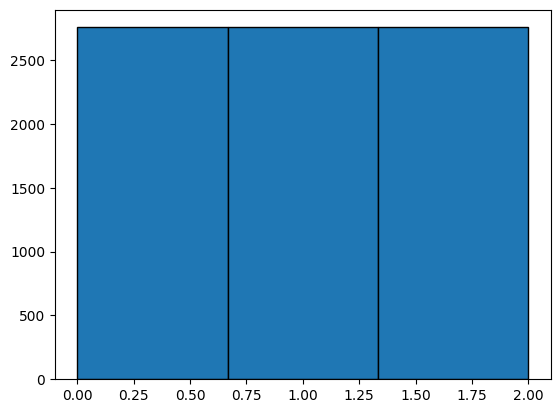

In [47]:
plt.hist(y_train, bins=3, edgecolor='black')

In [48]:
%%time

param_grid = {
    'max_depth': [8],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [475],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')

# Thiết lập GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Tối ưu hóa dựa trên accuracy
    n_jobs=3, 
    verbose=1
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# In tham số tốt nhất và điểm số
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 475, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.5172830553541213
CPU times: total: 32.3 s
Wall time: 26.7 s


In [49]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.3345

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.37      0.34       455
           1       0.31      0.24      0.27       387
           2       0.37      0.37      0.37       542

    accuracy                           0.33      1384
   macro avg       0.33      0.33      0.33      1384
weighted avg       0.33      0.33      0.33      1384


Confusion Matrix:
[[170  96 189]
 [143  93 151]
 [230 112 200]]


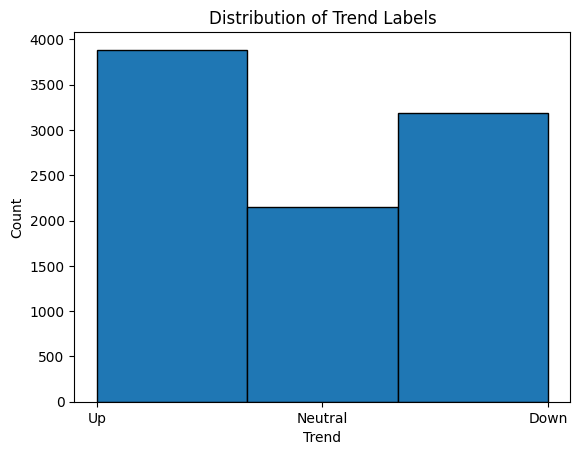

In [50]:
plt.hist(df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

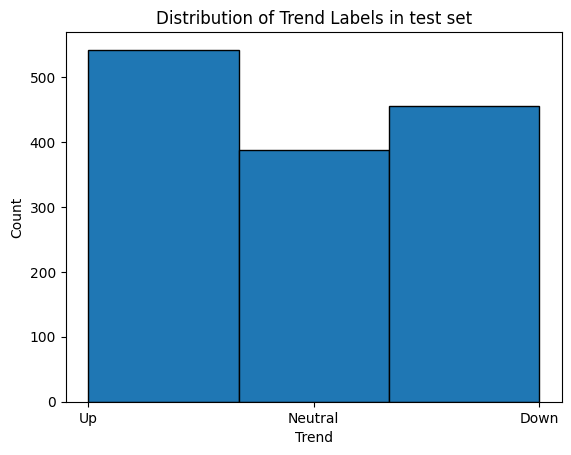

In [51]:
plt.hist(test_df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels in test set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

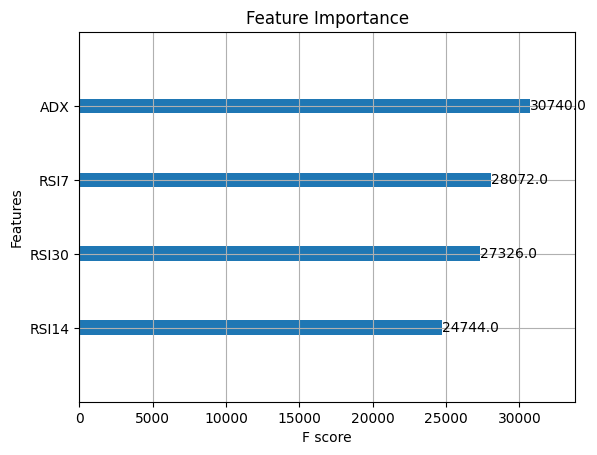

In [52]:
xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.show()